In [1]:
from tensorairspace.agent.ihdp.Critic import Critic

from tensorairspace.agent.ihdp.Incremental_model import IncrementalModel
from tensorairspace.agent.ihdp.Actor import Actor
from tensorairspace.agent.ihdp.Critic import Critic
from tqdm import tqdm
import numpy as np
from tensorairspace.aircraftmodel.model.f16.linear.longitudinal import set_initial_state, initial_state, LongitudinalF16
from tensorairspace.aircraftmodel.signals.sin import sinusoid

In [2]:
def unit_step(x):
    return np.deg2rad(5) * (x > 1000)

In [3]:
t0 = 0  # Начальное время
tn = 20  # Время моделирования
dt = 0.01  # Дисретизация
number_time_steps = int(((tn - t0) / dt) + 1)  # Количество шагов моделирования
time = list(np.arange(0, number_time_steps * dt, dt)) # Массив с шагов dt
t = np.linspace(-0, len(time), len(time))

#reference_signals = np.reshape([np.deg2rad(1) for x in time], [1, -1])
reference_signals =  np.reshape(unit_step(t),  [1, -1])
#reference_signals =  np.reshape(np.deg2rad(sinusoid(time,5,5)),  [1, -1])

In [4]:
selected_states = ['alpha', 'q']
selected_input = ['stab']
input_magnitude_limits = 25
input_rate_limits = 60
tracking_states = ['alpha']

In [5]:
indices_tracking_states = [selected_states.index(tracking_states[i]) for i in range(len(tracking_states))]

In [6]:
# actor settings

actor_start_training = 5
actor_layers = (25, 1)
actor_activations = ('tanh', 'tanh')
#actor_activations = ('tanh', 'sigmoid')
actor_learning_rate = 2
actor_learning_rate_cascaded = 1.2
actor_learning_rate_exponent_limit = 10
type_PE = 'combined'

amplitude_3211 = 15
pulse_length_3211 = 5/dt

maximum_input = 25
maximum_q_rate = 20


cascaded_actor = False
WB_limits = 30
NN_initial = 130

In [7]:
Q_weights = [8]
tracking_states = ['alpha']
critic_start_training = -1
gamma = 0.99
critic_learning_rate = 15
critic_learning_rate_exponent_limit = 10
critic_layers = (25, 1)
critic_activations = ("tanh", "linear")

In [8]:
actor = Actor(selected_input, selected_states, tracking_states, indices_tracking_states,
                 number_time_steps, actor_start_training, actor_layers, actor_activations,
                 actor_learning_rate, actor_learning_rate_cascaded, actor_learning_rate_exponent_limit,
                  type_PE, amplitude_3211, pulse_length_3211, WB_limits,
                 maximum_input, maximum_q_rate, cascaded_actor, NN_initial)
actor.build_actor_model()
critic = Critic(Q_weights, selected_states, tracking_states, indices_tracking_states, number_time_steps,
                 critic_start_training, gamma, critic_learning_rate, critic_learning_rate_exponent_limit, critic_layers,
                 critic_activations, WB_limits, NN_initial)
critic.build_critic_model()
incremental_model = IncrementalModel(selected_states, selected_input, number_time_steps, dt,
                 input_magnitude_limits, input_rate_limits)

[0]


2022-01-27 18:42:37.453551: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-01-27 18:42:37.477995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 18:42:37.478791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 3070 Laptop GPU computeCapability: 8.6
coreClock: 1.56GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-01-27 18:42:37.479855: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-27 18:42:37.483127: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-27 18:42:37.485012: I tensorflow/stream_executor/

In [9]:
alpha_states = []
initial_state = set_initial_state({'alpha':np.deg2rad(3)})

In [10]:
model = LongitudinalF16(initial_state, number_time_steps, selected_state_output=['alpha', 'q'])

In [11]:
xt = np.array([[np.deg2rad(3)], [0]])
for time_step in tqdm(range(number_time_steps-1)):
    xt_ref = np.reshape(reference_signals[:, time_step], [-1, 1])
    
    ut = actor.run_actor_online(xt, xt_ref)



    G = incremental_model.identify_incremental_model_LS(xt, ut)
    xt1_est = incremental_model.evaluate_incremental_model()

    xt_ref1 = np.reshape(reference_signals[:, time_step + 1], [-1, 1])
    
    _ = critic.run_train_critic_online_alpha_decay(xt, xt_ref)
    Jt1, dJt1_dxt1 = critic.evaluate_critic(np.reshape(xt1_est, [-1, 1]), xt_ref1)       
    actor.train_actor_online_alpha_decay(Jt1, dJt1_dxt1, G, incremental_model, critic, xt_ref1)
    
    incremental_model.update_incremental_model_attributes()
    critic.update_critic_attributes()
    actor.update_actor_attributes()

    xt = model.run_step(ut)
    xt_track = np.reshape(xt1[indices_tracking_states, :], [-1, 1])

  1%|          | 15/2000 [00:00<00:26, 73.90it/s]

[[7.5517354]]
[[7.538331]]
[[7.544944]]
[[7.544513]]
[[7.5520234]]
[[7.5456786]]
[[7.5436473]]
[[7.5379124]]
[[7.541381]]
[[7.542652]]
[[7.5535574]]
[[7.5448403]]
[[7.5446]]
[[7.548562]]
[[7.538966]]


  1%|          | 23/2000 [00:00<00:27, 71.58it/s]

[[7.538]]
[[7.540826]]
[[7.5352387]]
[[7.538264]]
[[7.545769]]
[[7.5301986]]
[[7.5330434]]
[[7.5307717]]
[[7.532669]]
[[7.5297475]]
[[7.5304766]]
[[7.5195584]]
[[7.5260444]]
[[7.526529]]
[[7.536628]]


  2%|▏         | 39/2000 [00:00<00:26, 73.20it/s]

[[7.527696]]
[[7.524728]]
[[7.5231013]]
[[7.5201187]]
[[7.519741]]
[[7.5271955]]
[[7.5189667]]
[[7.5206666]]
[[7.52721]]
[[7.512751]]
[[7.5120897]]
[[7.5107336]]
[[7.5076003]]
[[7.508314]]
[[7.512965]]


  3%|▎         | 55/2000 [00:00<00:30, 64.29it/s]

[[7.498215]]
[[7.5035305]]
[[7.501876]]
[[7.5078387]]
[[7.500912]]
[[7.4981685]]
[[7.490892]]
[[7.4940557]]
[[7.494477]]
[[7.504652]]
[[7.494982]]
[[7.493515]]


  3%|▎         | 69/2000 [00:01<00:30, 63.74it/s]

[[7.4960647]]
[[7.48637]]
[[7.484603]]
[[7.4872003]]
[[7.480481]]
[[7.482759]]
[[7.4895983]]
[[7.473244]]
[[7.4748898]]
[[7.47185]]
[[7.472403]]
[[7.4692616]]
[[7.469778]]


  4%|▍         | 76/2000 [00:01<00:30, 63.27it/s]

[[7.4576645]]
[[7.4635706]]
[[7.463205]]
[[7.472328]]
[[7.4628897]]
[[7.4591556]]
[[7.4562407]]
[[7.453478]]
[[7.4526453]]
[[7.46]]
[[7.4509687]]
[[7.451789]]
[[7.4574475]]


  4%|▍         | 90/2000 [00:01<00:31, 59.99it/s]

[[7.442828]]
[[7.4413624]]
[[7.4398136]]
[[7.435666]]
[[7.4362025]]
[[7.4407525]]
[[7.4251857]]
[[7.429661]]
[[7.427278]]
[[7.4321585]]
[[7.425151]]
[[7.4222083]]


  5%|▌         | 104/2000 [00:01<00:31, 59.54it/s]

[[7.413867]]
[[7.417135]]
[[7.4171324]]
[[7.426967]]
[[7.4168057]]
[[7.414555]]
[[7.4160943]]
[[7.4067445]]
[[7.404603]]
[[7.4073606]]
[[7.399872]]
[[7.4016523]]
[[7.407989]]


  6%|▌         | 118/2000 [00:01<00:30, 61.53it/s]

[[7.3909597]]
[[7.391189]]
[[7.3866234]]
[[7.3838444]]
[[7.375919]]
[[7.36627]]
[[7.3327065]]
[[7.3015704]]
[[7.2448754]]
[[7.1801753]]
[[7.0834374]]
[[6.98026]]
[[6.866286]]


  6%|▋         | 129/2000 [00:02<00:29, 63.94it/s]


[[6.743149]]
[[6.6105146]]
[[6.4756618]]
[[6.313137]]
[[6.1498632]]
[[5.9811416]]
[[5.7829666]]
[[5.5875936]]
[[5.3834176]]



KeyboardInterrupt



In [13]:
print("Статическая ошибка:",np.rad2deg(reference_signals[0][-1]-model.get_state('alpha')[-1]), "град.")
print("Перелегулирование:",(np.max(model.get_state('alpha')[1000:15000]) - reference_signals[0][1001])*100/reference_signals[0][1001], "%")

Статическая ошибка: 0.07608608278515301 град.
Перелегулирование: 39.181531166976384 %


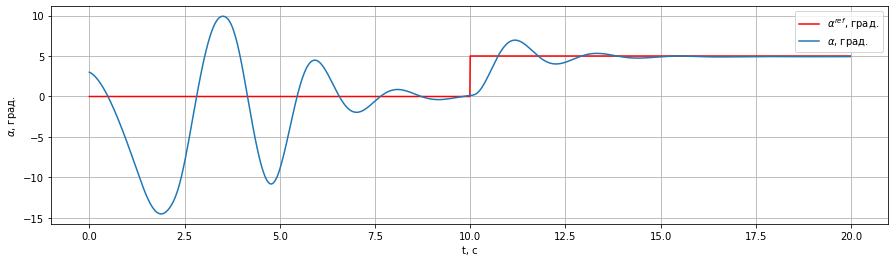

In [14]:
plot = model.plot_transient_process('alpha', time , reference_signals[0], to_deg=True, figsize=(15,4)) #  График переходного процесса по углу атаки